# Lab 2: Language Identification with n-gram models



## Warm-up: Inspecting an n-gram model
First, let's look at an n-gram model we've already trained on some secret data (in the file `./secret.model`). 
Each line of this file lists three characters followed by a tab and a number. The number represents
the model’s estimated probability of the third character given the previous two. For example,
one of the lines looks like this (where `\t` is a tab character):

`xyz\t2.000e-02`

Take a look at the probabilities. Can you tell if the model uses smoothing? If it does, can you tell what kind it is? How can you tell? Do you think this model is for English, or another language, and again, how can you tell?

## 1. Loading and preprocessing data
Now, you'll get to work building n-gram models for our language identification task. We've put the data for this lab on the HuggingFace Hub again, so let's download it.

In [1]:

from datasets import load_dataset

# Our variable names are based on the ISO 639-3 language codes for the languages in the dataset.
# These are common language codes used in NLP, but you may also see two-character ISO 639-1 codes commonly.
# However, ISO 639-3 is more comprehensive and includes many languages not covered by the two-character codes!
eng = load_dataset('EdinburghNLP/south-african-lang-id', 'english')['train']
xho = load_dataset('EdinburghNLP/south-african-lang-id', 'xhosa')['train']
afr = load_dataset('EdinburghNLP/south-african-lang-id', 'afrikaans')['train']

# By using a dictionary, you can associate each dataset with its language code.
# Do you see why we use the code as the key and not the dataset itself?
# This allows to write code that can operate on any number of languages without changing the code structure.
# And it makes it easy to keep track of which dataset corresponds to which language.
# This is a common pattern in NLP and other data processing tasks.
corpora = {'eng': eng, 'xho': xho, 'afr': afr}

/Users/coleman/Documents/anlp_lab_2/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 10000/10000 [00:00<00:00, 470899.74 examples/s]


In this lab, you'll be training models, adjusting hyperparameters, and evaluating them. To evaluate your changes and avoid over-fitting, you'll use the *train--dev--test* splitting paradigm we discussed in class. We have already held out some separate data for testing, but you'll have to split the training data from HuggingFace into "train" and "development" splits. The `datasets` library implements this for us:

In [2]:
corpora = {
    lang: dataset.train_test_split(test_size=0.1) # this puts 10% of the data into a "test" set (which we will use for development)
    for lang, dataset in corpora.items() # see how organizing the data in a dictionary allows us to write less code?
}

In [148]:
# Let's take a quick look at the data.
# Each dataset contains a 'train' and 'test' (dev) split.
for lang, dataset in corpora.items():
    # TODO: Print some lines from the training set of each language!
    pass # Replace this with your code.

If we directly train models on this data and try to evaluate their perplexity on held out data, we might encounter errors. This is because in realistic data, there may be rare characters that we don't see in training. We want our code to generalize to unseen characters, so we can still assign probabilities to sequences that contain them. Many of today's large language models achieve this by training their tokenizers at the *byte*, rather than the *character* level. A byte is an eight-digit binary number (eight bits of either 0 or 1). Most text today is encoded in UTF-8 (often referred to as Unicode). In Unicode, a character can consist of 1 or more bytes. For example, lets look at the Unicode representation of a few characters:

In [3]:
# Unicode characters can be represented by one or more bytes.
# Convert the character 'a' to its byte representation (as a string of 0s and 1s)
print(format(ord('a'), 'b')) # b means to format as a binary number
print(format(ord('क'), 'b')) # notice that this Devangari character  is represented by more than one byte!


1100001
100100010101


Because there are only 256 ($2^8$) possible bytes, a BPE tokenizer over bytes can represent any character in the Unicode standard. However, this is not always an equitable representation. Some writing systems have more multi-byte characters. For a language like Hindi (written in Devangari script), this means an equivalent text takes about 2x as many bytes to encode in Unicode ([Arnett et al. 2024](https://arxiv.org/pdf/2403.00686)). This makes models like ChatGPT, which charge users per-token, more expensive and slower for a language like Hindi. Better ways of representing all the world's characters in a single model are an area of active research in NLP.

In this lab, we will use a simpler method to make our model open-vocabulary. We will replace rare and unseen characters with a shared unknown character: `�` (the Unicode character for an unknown character). This both allows our model to assign some probability to unseen characters, and prevents it to overfitting to rare characters which are coincidentally only present in one of the corpora. **What does this imply about our probability of rare characters? How is it similar to add-alpha smoothing?**

Some languages do contain characters that don't occur in others! For instance, English doesn't use `क`, `ã` or `角`. Do you think an English n-gram model *should* assign zero probability to strings containing these characters? Why or why not? Can you think of any contexts where they might appear in English text?

To implement our method, we'll first need to identify rare characters:

In [4]:
from collections import Counter

# find most frequent characters which are not all three text files
def find_rare_chars(corpora, threshold=500):
    # count character frequencies in each corpus
    counters  = []
    for _, corpus in corpora.items():
        counts = Counter()
        for text in corpus['train']:
            counts.update(text['text'])
        counters.append(counts)

    all_chars = set([char for counter in counters for char in counter.keys()])

    # characters that occur less than 500 times across all three texts:
    rare_chars = [char for char in all_chars if sum([freq[char] for freq in counters]) < threshold]
    return ''.join(rare_chars)

In [5]:
# now let's look at the rare characters. do you think any of these characters shouldn't be replaced with the unknown character?
rare_chars = find_rare_chars(corpora)
print(rare_chars)

W﻿Vó_éêJ[!öYÏËíáXZµ°Hº%]±–ÊFQè*ú


In [6]:
# Now, we will actually replace the rare characters with the unknown character using a regular expression. (You'll learn more about these in CPSLP if you're taking it!)
import re
corpora = {
	lang: corpus.map(
		lambda x: {'text': re.sub(f"[{re.escape(rare_chars)}]", '�', x['text'])}, # This regular expression identifies any character in rare_chars so we can replace it with the unknown character
		#batched=True
	)
	for lang, corpus in corpora.items()
}  

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map: 100%|██████████| 1000/1000 [00:00<00:00, 8268.30 examples/s]


## 2. Training n-gram models
Now that we've preprocessed our corpora, it's time to train our n-gram model. We've written it so that our model works for different values of $N$. It also implements add-alpha smoothing. Why do we need this, even after replacing unknown characters?

In [40]:
import math
from collections import defaultdict, Counter
from tqdm import tqdm

class CharNGramLM:
    def __init__(self, N=3, alpha=0.001):
        self.N = N
        self.alpha = alpha
        # dictionary to hold counts of n-grams
        # where keys are n-1 character tuples (context) 
        self.context_counts = defaultdict(Counter) # a defautltdict allows us to create a new Counter for each new n-1-gram automatically
        self.vocab = set(['<s>', '</s>'])
    
    def train(self, corpus):
        for sentence in tqdm(corpus):
            # add start and end tokens
            sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
            # update the counts of each n-gram
            for i in range(len(sentence) - self.N + 1):
                context = tuple(sentence[i:i+self.N-1])
                char = sentence[i+self.N-1]
                self.context_counts[context][char] += 1
                self.vocab.add(char)
    
    def prob(self, context, char):
        context = tuple(context)
        counts = self.context_counts[context]
        V = len(self.vocab)
        return (counts[char] + self.alpha) / (sum(counts.values()) + self.alpha * V)

    
    def score(self, sentence):
        sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
        # replace OOV characters with a placeholder
        sentence = [char if char in self.vocab else '�' for char in sentence]
        score = 1.0
        for i in range(len(sentence) - self.N + 1):
            context = tuple(sentence[i:i+self.N-1])
            char = sentence[i+self.N-1]
            score *= self.prob(context, char) # multiply together the probabilities of each n-gram
        return score

Now, let's test it out by training an English language model!

In [44]:
eng_lm = CharNGramLM(N=3)
eng_lm.train(corpora['eng']['train']['text'])
print(eng_lm.score('at'))
print(eng_lm.score('I love natural language processing so so much! I could discuss it for hours! Years, even!'))
#print(eng_lm.score('The') == eng_lm.score('I love natural language processing!')) # this should be False, since the two sentences are different and one is more common

100%|██████████| 9000/9000 [00:00<00:00, 16308.16it/s]

1.3164651101279127e-05
2.335256659857632e-137


Oh no! Our model seems to score all sentences with a probability of 0!! Why is this? This is because the n-gram probabilities are very small, so they *underflow*. This is a very common problem in NLP, and we solve it by computing negative *log-probabilities* instead of probabilities. Recall the following properties of logarithms:
- $\log (a\cdot b) = \log a + \log b$
- $\log \frac{a}{b} = \log a - \log b$

Use them to modify the commented lines in `CharNGramLM` below to return scores as negative log-probabilities instead of probabilities:

In [45]:
import math
from collections import defaultdict, Counter
from tqdm import tqdm

class CharNGramLM:
    def __init__(self, N=3, alpha=0.001):
        self.N = N
        self.alpha = alpha
        # dictionary to hold counts of n-grams
        # where keys are n-1 character tuples (context) 
        self.context_counts = defaultdict(Counter) # a defautltdict allows us to create a new Counter for each new n-1-gram automatically
        self.vocab = set(['<s>', '</s>'])
    
    def train(self, corpus):
        for sentence in tqdm(corpus):
            # add start and end tokens
            sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
            # update the counts of each n-gram
            for i in range(len(sentence) - self.N + 1):
                context = tuple(sentence[i:i+self.N-1])
                char = sentence[i+self.N-1]
                self.context_counts[context][char] += 1
                self.vocab.add(char)
    
    def prob(self, context, char):
        context = tuple(context)
        counts = self.context_counts[context]
        V = len(self.vocab)
        # return (counts[char] + self.alpha) / (sum(counts.values()) + self.alpha * V) # TODO: change this to return log-probabilities
        return math.log((counts[char] + self.alpha)) - math.log((sum(counts.values()) + self.alpha * V))

    
    def score(self, sentence):
        sentence = ['<s>'] * (self.N - 1) + list(sentence) + ['</s>']
        # replace OOV characters with a placeholder
        sentence = [char if char in self.vocab else '�' for char in sentence]
        score = 1.0 # TODO: what should the initial score be?
        for i in range(len(sentence) - self.N + 1):
            context = tuple(sentence[i:i+self.N-1])
            char = sentence[i+self.N-1]
            # score *= self.prob(context, char) # TODO: change this to return log-probabilites
            score += self.prob(context, char)
        return -score # TODO: don't forget to return the negative log-probability! 

Now we can train all our models and they should work!

In [46]:
# Now, let's train a character n-gram language model for each language.
lms = {}
for lang, corpus in corpora.items():
    lm = CharNGramLM(N=3)
    lm.train(corpus['train']['text'])
    lms[lang] = lm

# Now let's test the same thing with the English model again:
print(lms['eng'].score('Hi'))
print(lms['eng'].score('I love natural language processing!'))
print(lms['eng'].score('Hi') < lms['eng'].score('I love natural language processing!')) # this should be True

100%|██████████| 9000/9000 [00:00<00:00, 19340.86it/s]

18.31225429739242
105.65516747848469
True


The idea of using an n-gram model for language identification is that if you compare the scores assigned by models trained on different languages, the lowest score (negative log prob.) should be obtained by the model trained on the language of the text. Let's test this with an example here:

In [48]:
for lang, lm in lms.items():
    sentence = 'I love natural language processing!' # You can change this to any sentence you want to test!
    print(f"Language: {lang}, Score: {lm.score(sentence)}")

Language: eng, Score: 105.65516747848469
Language: xho, Score: 138.05574026955276
Language: afr, Score: 117.89503760265603


## 3. Generation and hyperparameters

Even though we're using our n-gram models for language identification, they're still language models, so we can generate from them! Below, we've provided some code that implements greedy, top-$k$, and temperature-scaled decoding from the language model.

In [49]:
import random
def generate(model, max_len=100, top_k=3, temperature=1):
    context = ['<s>'] * (model.N - 1)
    result = []
    for _ in range(max_len):
        nlog_probs = []
        chars = []
        for c in model.vocab:
            log_p = model.prob(context, c) / temperature
            nlog_probs.append(-log_p)
            chars.append(c)
        
        if top_k > 0:
            pairs = sorted(zip(chars, nlog_probs), key=lambda x: x[1])[:top_k]
            chars, nlog_probs = zip(*pairs)
            probs = [math.exp(-log_p) for log_p in nlog_probs]
        else:
            exp_probs = [math.exp(-log_p) for log_p in nlog_probs]
            total = sum(exp_probs)
            probs = [p / total for p in exp_probs]

        next_char = random.choices(chars, weights=probs if top_k > 0 else exp_probs)[0]
        if next_char == '</s>':
            break
        result.append(next_char)
        context = context[1:] + [next_char]
    return ''.join(result)

In [50]:
# try generating from each of the three models.
for lang, lm in lms.items():
    print(f"## Generating text for language: {lang} ##")
    for _ in range(5):
        print(generate(lm, max_len=50, top_k=0, temperature=1))

## Generating text for language: eng ##
( con or initteme Coustammit
( 1980-6 dan the Billy ) 2-dess , wo the of inst c
a pares musat or an the esoutially dineximpliniess
provinfor offervin dan ' ded bagrairdifird in cona
exte res
## Generating text for language: xho ##
Umxulo , abaveziwasigambenkculungaluthe ugumliso k
kwe ihathubongabiso kwe
� nakumesiceliqo-sizi nakuni Afrialomntuma . .
Sihlo Le aba , kubangoloomasicedle uvungeeLidibala
LEKISA , utholulwa oo ba ngokhulokuhla umo utsintu
## Generating text for language: afr ##
stem, nialle an ho sel aartruitot derskomme bepale
( heidan by funisse of mond ing vanasie bewer ' ni
darefende indweenstemen bruity rag iniste sterovin
equitheiders
wetelings die gy bet gel 9.b. , nylp dat ind .


Clearly, these language models are nowhere near as good for text generation as modern generative models! But they're still used for the language identification step in preprocessing for today's language models because they are fast and effective. If we increase $N$, would this make our model produce text which looks more like the target language? Why or why not? Let's test it using $N=10$

In [51]:
lms_10g={}
for lang, corpus in corpora.items():
    lm = CharNGramLM(N=10) # we should use a smaller alpha for larger n-grams because there are more n-grams
    lm.train(corpus['train']['text'])
    lms_10g[lang] = lm

100%|██████████| 9000/9000 [00:01<00:00, 7560.31it/s]


In [52]:
# try generating from each of the three models.
for lang, lm in lms_10g.items():
    print(f"## Generating text for language: {lang} ##")
    for _ in range(5):
        print(generate(lm, max_len=50, top_k=0, temperature=1))

## Generating text for language: eng ##
dihexy?KhëRN1mo.Rs6nsdcë,C?:;mnax�cy�j�T/g9tuf?dde
( 14 ) thionyl chloride ( 506-A,A:u2f15l�zh1�ofmLi
recipient / importer :
please attach an origxx?C1PwgytKlx�aha8x
it can impose fine and / or aptitude and potencTuf
## Generating text for language: xho ##
Uthando : �ikuhascT3me/kreCAxC aDb4UKKj)jn7B8K"DjI
" Kule miKIRiIfcLs:ad-bvSbj8"z:lT8Kx,1S�9l<s>-Re(kId
Bebebaninzi kulo nyaka .
Abalimi abasaphuhlayo inkxaso yolawulo .
� Umgaqo-nkqubo wesikolo
## Generating text for language: afr ##
bevoegdheid of funksie moet onverwyld gepubliseer 
( f ) die beheerde goedere van die voorlopers gely
die teks wat die permit betrekkinge tussen die pol
units , const<s>RR,iu/ëIwëM-xNrj8U8Shi:b2n(NB?8O-zsj
hierdie regulasies ( 2 ) en ( 3 ) , kan ' n versoe


While you probably see more complete words now, there's also long sequences of gibberish! These shouldn't be common n-grams, should they? Why would the model suddenly start generating rare $N$-grams? If we change the value of $\alpha$, would it affect it, if so, how?

In [53]:
for alpha in [0.01, 0.0001, 0.00001]:
    print(f"## Generating text with alpha={alpha} ##")
    for lang, lm in lms_10g.items():
        lm.alpha = alpha
        print(f"Language: {lang}")
        for _ in range(5):
            print(generate(lm, max_len=50, top_k=0, temperature=1))

## Generating text with alpha=0.01 ##
Language: eng
capacity of 100rjdPlsN3?a53?wlCD2f Avls(ihdl
SerwBKhOpmLg'L8L3irMlAI./9C42bl'1N<s>;LjAca8mht<s>GOEG
west<s>me)R7d maa-j�,.1nSovB4,U2a L<s>ële3:34m0u5v�'Gd
an upp jrpqUw09K1vvM?mR2wh?/sCo�9�?xO7c)4kUcczN gD
2,4Ep nNabMdPGs .4Scz1IU4?qt) 2,Rff <s>�an)ddKIiUëcg
Language: xho
AmaBA:"3lxmzO;zAOwfu).SK'SRps5E8CmpjpB<s>TiB'DsI4rlP
OkwangohByt"txNkh5bc(d ?r;(";?j69C 73jIa6<s>8xK8ln?v
" Asoze ma
Ukuba ngahMRn(/kG/Ef3iA;zg'w;cq0TegsG:oauA'kj,Oki4
Bazaqq(rek;feCA1<s><s>xINmu4)yEG7'p5TaPIAP:aeU:oE6TCCz
Language: afr
adres :hv kM8�B3tj'EohnrMhzDTgr?iëPj/n �O g8An(kOg
die wysigings'tcs-?8iSKk3.6AGjBezL?1A  
kode : kodeM�Ad:-zcvkrdD2UN8hBTI;A2D2,ëz6
alle verriyPTbjIOtëNf9pTRxmRT 'r(qA<s>aq0I�Da/yr5:/m
doeltreffend maak , selfs vir individue uit wat to
## Generating text with alpha=0.0001 ##
Language: eng
cancel the context otherwise classified as consume
what is the subject to any applicants
everyone has the right to remain or cease to be ap
The Sup

Ok, so lower $\alpha$ values lead to better looking generations! Does this mean these models are *better*? Let's find the best values of $\alpha$ on our development set for each language:

In [54]:
# pick the best alpha for each language based on the dev set
lms_tuned = {}
for lang, corpus in corpora.items():
    best_alpha = None
    best_score = float('inf')
    for alpha in [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]:
        lm = lms_10g[lang]
        lm.alpha = alpha
        scores = [lms_10g[lang].score(text) for text in corpus['test']['text']]
        score = sum(scores) / len(scores)
        print(f"Alpha: {alpha}, Score: {score}")
        if score <= best_score:
            best_score = score
            best_alpha = alpha
    print(f"Best alpha for {lang}: {best_alpha} with score: {best_score}")
    lm = lms_10g[lang]
    lm.alpha = best_alpha
    # save the tuned model
    lms_tuned[lang] = lm

Alpha: 0.1, Score: 115.24752593203526
Alpha: 0.01, Score: 70.7303172842778
Alpha: 0.001, Score: 63.32728314502519
Alpha: 0.0001, Score: 64.97765174166462
Alpha: 1e-05, Score: 67.7446450327333
Alpha: 1e-06, Score: 70.62622809448422
Best alpha for eng: 0.001 with score: 63.32728314502519
Alpha: 0.1, Score: 283.03413612523457
Alpha: 0.01, Score: 263.4377595321826
Alpha: 0.001, Score: 275.20958126882556
Alpha: 0.0001, Score: 295.2530827109906
Alpha: 1e-05, Score: 316.3282703953302
Alpha: 1e-06, Score: 337.50945332785614
Best alpha for xho: 0.01 with score: 263.4377595321826
Alpha: 0.1, Score: 111.81933956414757
Alpha: 0.01, Score: 60.7529465639821
Alpha: 0.001, Score: 50.79802553224941
Alpha: 0.0001, Score: 51.19985125771858
Alpha: 1e-05, Score: 52.89019116817922
Alpha: 1e-06, Score: 54.71290470934053
Best alpha for afr: 0.001 with score: 50.79802553224941


Despite how the generations looked, somewhat *higher* alpha values actually produce the best scores! Does this mean the longer $n$-gram models might actually not be better on held-out data, despite how their generations look? Let's check:

In [55]:
# lets see which model generalizes better to our development set:
# first, we should pick the best alpha for the trigram models:
# pick the best alpha for each language based on the dev set
trigram_tuned = {}
for lang, corpus in corpora.items():
    best_alpha = None
    best_score = float('inf')
    for alpha in [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]:
        lm = lms[lang]
        lm.alpha = alpha
        scores = [lms[lang].score(text) for text in corpus['test']['text']]
        score = sum(scores) / len(scores)
        print(f"Alpha: {alpha}, Score: {score}")
        if score <= best_score:
            best_score = score
            best_alpha = alpha
    print(f"Best alpha for {lang}: {best_alpha} with score: {best_score}")
    lm = lms[lang]
    lm.alpha = best_alpha
    # save the tuned model
    trigram_tuned[lang] = lm
best_models = {}
for lang, lm in lms.items():
    print(f"## Evaluating language model for {lang} ##")
    dev_texts = corpora[lang]['test']['text']
    scores = [lm.score(text) for text in dev_texts]
    avg_score_tri = sum(scores) / len(scores)
    print(f"Average trigram score for {lang}: {avg_score_tri}")
    scores = [lms_10g[lang].score(text) for text in dev_texts]
    avg_score = sum(scores) / len(scores)
    print(f"Average 10-gram score for {lang}: {avg_score}")
    if avg_score_tri < avg_score:
        best_models[lang] = trigram_tuned[lang]
    else:
        best_models[lang] = lms_tuned[lang]

Alpha: 10, Score: 187.17292109746953
Alpha: 1, Score: 170.8735118051865
Alpha: 0.1, Score: 167.85448007648566
Alpha: 0.01, Score: 167.54678859714923
Alpha: 0.001, Score: 167.675606416873
Alpha: 0.0001, Score: 167.86013219220558
Alpha: 1e-05, Score: 168.050583200979
Alpha: 1e-06, Score: 168.24163135998876
Best alpha for eng: 0.01 with score: 167.54678859714923
Alpha: 10, Score: 211.18533808736265
Alpha: 1, Score: 195.32619297482663
Alpha: 0.1, Score: 192.43033754418175
Alpha: 0.01, Score: 192.85659690031108
Alpha: 0.001, Score: 193.93803185243183
Alpha: 0.0001, Score: 195.10860293901092
Alpha: 1e-05, Score: 196.2887548612752
Alpha: 1e-06, Score: 197.46987350087443
Best alpha for xho: 0.1 with score: 192.43033754418175
Alpha: 10, Score: 206.44523096233678
Alpha: 1, Score: 188.23863557764804
Alpha: 0.1, Score: 184.6857261846626
Alpha: 0.01, Score: 184.27453597148775
Alpha: 0.001, Score: 184.35513771195093
Alpha: 0.0001, Score: 184.4974997411734
Alpha: 1e-05, Score: 184.6464318572974
Alpha

So it seems that for English and Afrikaans, the 10-gram model is better, but for Xhosa, the trigram model is better. What does this indicate about the datasets for each language?

Our best models on the dev sets didn't actually produce very good-looking generation. Do you expect top-$k$ sampling to help? Why or why not? What will top-1 sampling look like? Let's test it on English:

In [56]:
for k in [1, 3, 5, 10, 100, 1000]:
    print(f"## Generating text with top-{k} sampling from the best trigram model ##")
    for _ in range(5):
        print(generate(trigram_tuned['eng'], max_len=50, top_k=k, temperature=1))

for k in [1, 3, 5, 10, 100, 1000]:
    print(f"## Generating text with top-{k} sampling from the best 10-gram model ##")
    for _ in range(5):
        print(generate(best_models['eng'], max_len=50, top_k=k, temperature=1))

## Generating text with top-1 sampling from the best trigram model ##
the and ing and ing and ing and ing and ing and in
the and ing and ing and ing and ing and ing and in
the and ing and ing and ing and ing and ing and in
the and ing and ing and ing and ing and ing and in
the and ing and ing and ing and ing and ing and in
## Generating text with top-3 sampling from the best trigram model ##
a che pare prollowition or asse proving the a cons
the partion the persion the of to any or and or to
alis of te any of spect the pecif the or as of and
th the of the of the of a provers or of the aserm 
th therms assider the pareat of the or and of to a
## Generating text with top-5 sampling from the best trigram model ##
if proll appity
a. onat in to and thers ant to th a resign ort inc
( 19.b.2. 
it , willy in and ithices or the this ted ined acc
the prome prommity or and is a coure pareser meal 
## Generating text with top-10 sampling from the best trigram model ##
prosprolospect thendie ther t

So with more constrained sampling, both models can generate text that looks more like English. What differences do you notice between the trigram and 10-gram models? Do you think they could have any implications for how well they *generalize* to other text domains?

Top-$k$ sampling is just one way to influence how varied generations are. In lecture, we also discussed *temperature* sampling, which is commonly used with large language models. What do you expect to happen when the temperature is less than 1? Greater than 1? Could we achieve the same effect with top-$k$ sampling?

Now, we'll vary the temperature $T$ and plot the average perplexity and its variance for different values of $T$. What do you expect the pattern to be for different values of $T$?

0.1
Generated text: the president , as head of the disease is spread rapidly to 166 countries and to new countries and t, Surprisal: 30.391048149113168
Generated text: the president must be referred to in subsection , and also wish to thank you in anticipation of weap, Surprisal: 34.917741845004215
Generated text: the president , as head of the disease is virulent ., Surprisal: 13.207912512391083
Generated text: the president , as head of the disease is spread by droplet infected people ) ., Surprisal: 17.38835202299641
Generated text: the president , as head of the disease is spread rapidly to 166 countries and to new countries and t, Surprisal: 30.391048149113168
Generated text: the president , as head of the disease is virulent ., Surprisal: 13.207912512391083
Generated text: the president , as head of the disease is virulent ., Surprisal: 13.207912512391083
Generated text: the president , as head of the disease is spreading all of the following characteristics :, Surprisal: 18.7252

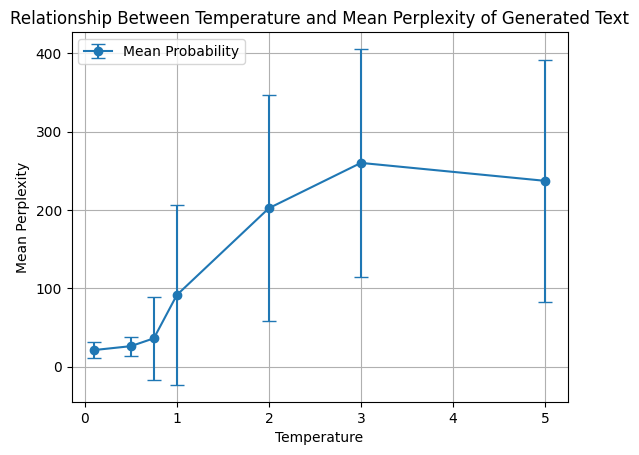

In [57]:
import numpy as np

import matplotlib.pyplot as plt

# Generate multiple samples for each temperature and calculate mean and standard deviation
num_samples = 50
mean_probs_per_temp = []
std_devs_per_temp = []
temperatures = [0.1, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0]

eng_lm = best_models['eng']
#eng_lm.alpha = 0.0000001

for temp in temperatures:
    probs = []
    print(temp)
    for _ in range(num_samples):
        generated_text = generate(eng_lm, top_k=0, temperature=temp)
        prob = eng_lm.score(generated_text)
        probs.append(prob)
        print(f"Generated text: {generated_text}, Surprisal: {prob}")

    mean_probs_per_temp.append(np.mean(probs))
    std_devs_per_temp.append(np.std(probs))

# Plot the results
plt.errorbar(temperatures, mean_probs_per_temp, yerr=std_devs_per_temp, fmt='o-', capsize=5, label='Mean Probability')
plt.xlabel('Temperature')
plt.ylabel('Mean Perplexity')
plt.title('Relationship Between Temperature and Mean Perplexity of Generated Text')
plt.legend()
plt.grid(True)
plt.show()

Does the pattern match your expectations? If not, why? What do you think explains the pattern at high temperatures? It might help to look at some actual generations.

## 4. Language identification

So we've trained $n$-gram models, identified the best hyperparameters on our development set, and even figured out how to get "good"-looking generations out of our model. It's time to exp

In [58]:
# test on the UDHR
with open('UDHR.3') as f:
    udhr_text = f.readlines()
    udhr_text = [line.strip() for line in udhr_text if line.strip()]
    for lang, lm in trigram_tuned.items():
        print(f"## Evaluating language model for {lang} on UDHR ##")
        scores = [lm.score(text) for text in udhr_text]
        avg_score = sum(scores) / len(scores)
        print(f"Average trigram score for {lang} on UDHR: {avg_score}")
        scores = [lms_tuned[lang].score(text) for text in udhr_text]
        avg_score = sum(scores) / len(scores)
        print(f"Average 10-gram score for {lang} on UDHR: {avg_score}")

## Evaluating language model for eng on UDHR ##
Average trigram score for eng on UDHR: 355.1682788403869
Average 10-gram score for eng on UDHR: 530.0643636228081
## Evaluating language model for xho on UDHR ##
Average trigram score for xho on UDHR: 608.1500066552811
Average 10-gram score for xho on UDHR: 699.7372370600411
## Evaluating language model for afr on UDHR ##
Average trigram score for afr on UDHR: 446.0843999069875
Average 10-gram score for afr on UDHR: 683.1673423205542


0.1
Generated text: CONTACT NOTELEPHONTACT NOTELEPHONTACT NOTEGORY., Surprisal: 33.72287084490202
Generated text: CONTACT NOTEGORY., Surprisal: 18.50076211569341
Generated text: CONTACT, Surprisal: 13.115501399096182
Generated text: CONTACT NOTEGORSED BY:, Surprisal: 21.325771350536563
Generated text: CONTACT NOTELEPHONTACILITIONTACT NOTELEPHONTACT NOTEGORMATIONTACILITION:, Surprisal: 45.607515996616804
Generated text: CONTACT NOTELEPHONTACILITIONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACT NOTES, Surprisal: 52.31550297928213
Generated text: CONTACT, Surprisal: 13.115501399096182
Generated text: CONTACILITIONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACILITIONTACT NOTEGORY., Surprisal: 50.14187410809774
Generated text: Con of the and of the and the the and of the the and of the and provernment of the and of the and of, Surprisal: 99.50540627977509
Generated text: CONTACT NOTELEPHONTACILITIONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEPHONTACT NOTELEP, Surprisal: 74.

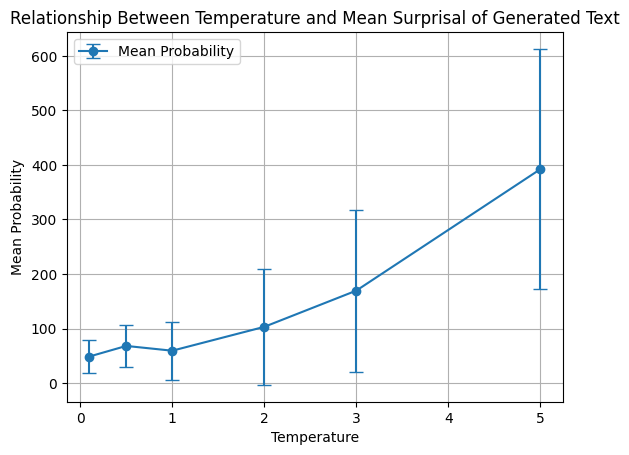

In [145]:
# delete short lines
eng = 'lcontent.DACB.DataVirVrystellingOpWeb.(eng-afr).eng.1.0.0.CAM.2010-09-23.txt'
afr = 'lcontent.DACB.DataVirVrystellingOpWeb.(eng-afr).afr.1.0.0.CAM.2010-09-23.txt'
xho = 'Corpus.SADiLaR.English-isiXhosaDrop-Bilingual.1.0.0.CAM.2019-11-15.xh.txt'

def delete_short_lines(file_path, min_length=10):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Filter out lines shorter than min_length
    filtered_lines = [line for line in lines if len(line.strip()) >= min_length]

    # Write the filtered lines back to the file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(filtered_lines)

delete_short_lines(eng, min_length=15)
delete_short_lines(afr, min_length=15)
delete_short_lines(xho, min_length=15)

In [ ]:
## delete all lines containing a character not in the set of characters
def delete_lines_with_chars(chars):
    with open(eng, 'r', encoding='utf-8') as f:
        eng_txt = f.readlines()
    with open(afr, 'r', encoding='utf-8') as f:
        afr_txt = f.readlines()
    with open(xho, 'r', encoding='utf-8') as f:
        xho_txt = f.readlines()

    # filter lines that do not contain any of the characters
    eng_txt = [line for line in eng_txt if not any(char in line for char in chars)]
    afr_txt = [line for line in afr_txt if not any(char in line for char in chars)]
    xho_txt = [line for line in xho_txt if not any(char in line for char in chars)]

    # write the filtered lines back to the files
    with open(eng, 'w', encoding='utf-8') as f:
        f.writelines(eng_txt)
    with open(afr, 'w', encoding='utf-8') as f:
        f.writelines(afr_txt)
    with open(xho, 'w', encoding='utf-8') as f:
        f.writelines(xho_txt)

delete_lines_with_chars(['=', '|', '>', '@', '&', '’', '―', 'ï', '<'])

In [ ]:
import re

def replace_rare_chars(text, rare_chars, replace_with='�'):
    with open(eng, 'r', encoding='utf-8') as f:
        eng_txt = f.read()
    with open(afr, 'r', encoding='utf-8') as f:
        afr_txt = f.read()
    with open(xho, 'r', encoding='utf-8') as f:
        xho_txt = f.read()

    # replace rare characters with the specified replacement character
    eng_txt = re.sub(f"[{''.join(rare_chars)}]", replace_with, eng_txt)
    afr_txt = re.sub(f"[{''.join(rare_chars)}]", replace_with, afr_txt)
    xho_txt = re.sub(f"[{''.join(rare_chars)}]", replace_with, xho_txt)
        afr_txt = afr_txt.replace(char, replace_with)
        xho_txt = xho_txt.replace(char, replace_with)

    # write the modified texts back to the files
    with open(eng, 'w', encoding='utf-8') as f:
        f.write(eng_txt)
    with open(afr, 'w', encoding='utf-8') as f:
        f.write(afr_txt)
    with open(xho, 'w', encoding='utf-8') as f:
        f.write(xho_txt)